In [24]:
import pandas as pd

# path relative to notebook
df = pd.read_csv("data/retail_dataset.csv")

print("Data loaded successfully!")
print(df.shape)
df.head()

Data loaded successfully!
(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [25]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [26]:
# Check missing CustomerIDs
print("Missing CustomerIDs:", df['CustomerID'].isnull().sum())

# Drop missing CustomerIDs
df = df.dropna(subset=['CustomerID'])

# Convert CustomerID to string (so grouping works cleanly later)
df['CustomerID'] = df['CustomerID'].astype(str)

print("Null CustomerIDs removed.")
print("New shape:", df.shape)

Missing CustomerIDs: 135080
Null CustomerIDs removed.
New shape: (406829, 8)


In [27]:
# Drop negative quantities
df = df[df['Quantity'] > 0]

# Drop invoices that start with 'C' (cancelled)
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

print("Removed cancelled or negative transactions.")
print("New shape:", df.shape)

Removed cancelled or negative transactions.
New shape: (397924, 8)


In [28]:
df = df[df['UnitPrice'] > 0]
print("Removed rows with non-positive prices.")
print("New shape:", df.shape)


Removed rows with non-positive prices.
New shape: (397884, 8)


In [30]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

print("Converted InvoiceDate to datetime.")
print(df['InvoiceDate'].dtypes)


Converted InvoiceDate to datetime.
datetime64[ns]


In [31]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
print("Added TotalPrice column.")
df.head(3)


Added TotalPrice column.


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00


In [32]:
import datetime as dt

snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
print("Snapshot date:", snapshot_date)


Snapshot date: 2011-12-10 12:50:00


In [33]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                  # Frequency
    'TotalPrice': 'sum'                                      # Monetary
})

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [34]:
rfm.describe()


,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2054.266460
std,100.014169,7.697998,8989.230441
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,307.415000
50%,51.000000,2.000000,674.485000
75%,142.000000,5.000000,1661.740000
max,374.000000,209.000000,280206.020000


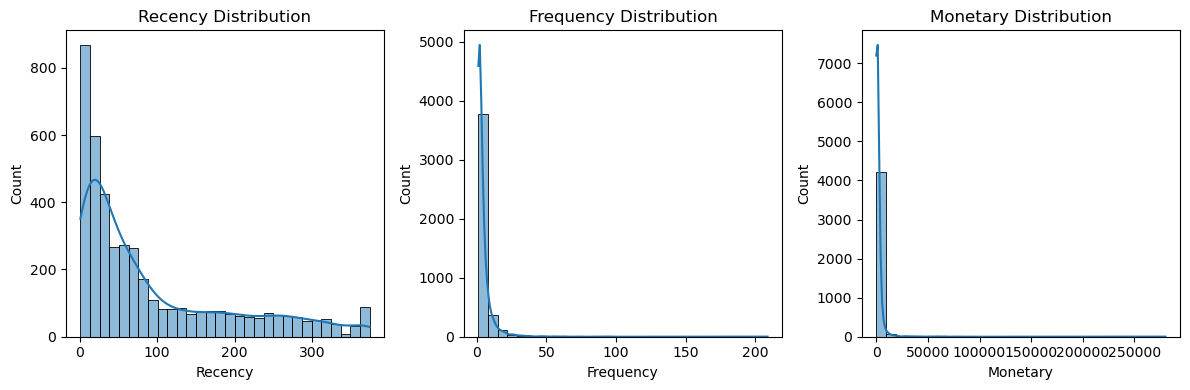

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

for i, col in enumerate(['Recency', 'Frequency', 'Monetary']):
    plt.subplot(1, 3, i+1)
    sns.histplot(rfm[col], bins=30, kde=True)
    plt.title(f'{col} Distribution')

plt.tight_layout()
plt.show()


In [36]:
import numpy as np

rfm_log = rfm.copy()
rfm_log['Recency_log']   = np.log1p(rfm['Recency'])
rfm_log['Frequency_log'] = np.log1p(rfm['Frequency'])
rfm_log['Monetary_log']  = np.log1p(rfm['Monetary'])

rfm_log = rfm_log[['Recency_log', 'Frequency_log', 'Monetary_log']]
rfm_log.head()


,Recency_log,Frequency_log,Monetary_log
CustomerID,,,
12346.0,5.789960,0.693147,11.253955
12347.0,1.098612,2.079442,8.368925
12348.0,4.330733,1.609438,7.494564
12349.0,2.995732,0.693147,7.472245
12350.0,5.739793,0.693147,5.815324


In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

import pandas as pd
rfm_scaled = pd.DataFrame(rfm_scaled,
                          index=rfm_log.index,
                          columns=rfm_log.columns)

print("Data standardized successfully.")
rfm_scaled.head()


Data standardized successfully.


,Recency_log,Frequency_log,Monetary_log
CustomerID,,,
12346.0,1.461993,-0.955214,3.706225
12347.0,-2.038734,1.074425,1.411843
12348.0,0.373104,0.386304,0.716489
12349.0,-0.623086,-0.955214,0.698739
12350.0,1.424558,-0.955214,-0.618962


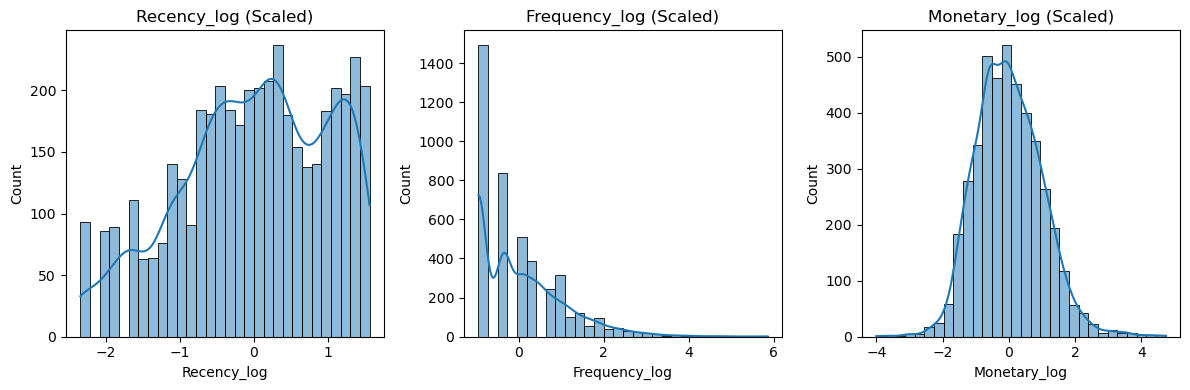

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
for i, col in enumerate(rfm_scaled.columns):
    plt.subplot(1,3,i+1)
    sns.histplot(rfm_scaled[col], bins=30, kde=True)
    plt.title(f'{col} (Scaled)')
plt.tight_layout()
plt.show()
